<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone V (2)</font></h2>

<h1><font color="#00586D" size=5>Análisis y predicción de un conjunto de datos sobre precios de viviendas</font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>Luis de la Ossa</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>
<br>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>

#### <font color="#00586D"> Notebook I</font>
* [1. Introducción](#section1)
* [2. Preparación de los datos](#section2)
* [3. Exploración preliminar](#section3)

#### <font color="#00586D"> Notebook II</font>
* [4. Predicción con modelos básicos](#section4)
* [5. Ensembles](#section5)
* [6. Explicabilidad](#section6)
* [7. KNN](#section7)
* [8. Construcción de características](#section8)
* [9. Descarte de outliers](#section9)
* [10. Aprendizaje no supervisado: PCA, Manifold y EM](#section10)


---
<br>

En este proyecto se aborda un problema de análisis y predicción de precios de viviendas a partir de un conjunto de datos que se ha obtenido de [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). En la libreta anterior, se preprocesaron estos datos y se hizo una pequeña exploración. El resultado se almacenó en el archivo  `data/houses_prep.csv`. En esta libreta se llevará a cabo el desarrollo del proyecto.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>  A diferencia de proyectos anteriores, en este caso no se trabajará en pasos sucesivos hasta lograr un objetivo, sino que se resolverán ejercicios de distinta índole relacionados con algunas de las técnicas vistas en clase. Por otra parte, **aunque la lectura del proyecto es larga, los ejercicios son cortos** (relativamente 🤓).
</div>


In [2]:
data = pd.read_csv('data/houses_prep.csv', index_col=0, na_values='NA')
#df_houses.info()
data.shape

(1460, 227)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a>
## <font color="#00586D"> 4. Predicción con modelos básicos</font>
<br>

En este apartado se implementarán unos modelos básicos iniciales sobre los que se trabajará posteriormente para intentar refinar el modelo. A continuación, se crean los conjuntos de datos de entrenamiento y test (33% de los datos). Debido a que el conjunto de datos es pequeño, se utilizará validación cruzada para seleccionar el modelo y determinar los parámetros. 

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='SalePrice').copy()
y = data['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)

(978, 226)
(482, 226)


Para simplificar el código se proporciona una función auxiliar que muestra los resultados de un modelo con respecto a entrenamiento, validación, y test. El parámetro `is_log` permite indicar si se ha pasado el logaritmo de la clase como variable objetivo (veremos después por qué).  Por otra parte, los resultados de los algoritmos se irán almacenando en un *DataFrame* denominado `results` con el fin de que se puedan visualizar fácilmente. Es importante que el nombre del modelo (primer parámetro de la función, `description`) sea representativo y único.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


# DataFrame con los resultados
results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Validación','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
results

def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    val_r2 = cross_val_score(model,X_train,y_train,cv=5).mean()
    test_r2 = model.score(X_test, y_test)
    
    # Si se utiliza el logaritmo de la variable objetivo hay que 
    # convertirlo para calcular el error
    f = np.exp if is_log else lambda y: y
    # Calcula el error    
    train_mae = mean_absolute_error(f(y_train), f(model.predict(X_train)))
    test_mae = mean_absolute_error(f(y_test), f(model.predict(X_test)))
    
    # Muetra los resultados en formato legible
    print('Training \t\txValidation \t\tTest')
    print('-------- \t\t----------- \t\t----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {val_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    
    results.loc[description]= (train_r2, val_r2, test_r2, train_mae, test_mae)

---

### <font color="#00586D">Regresión lineal con regularización</font>
<br>



El modelo básico con el que comenzaremos a trabajar es una regresión lineal con regularización L2 (`Ridge()`). 


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 1</font> 

Entrenar un modelo `Ridge()`. Se utilizará `GridSearchCV` (con 5 particiones) para determinar el valor óptimo de `alpha`. El modelo final se almacenará en la variable `ridge`, y se mostrará el resultado con `show_results`.


<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Para evaluar y comparar modelos **utizaremos, estrictamente,** los resultados de entrenamiento y validación cruzada. El resultado de test es informativo, y **en ningún momento lo utilizaremos para hacer ajustes**.
</div>

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
 
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression'
show_results(description, ridge, X_train, y_train, X_test, y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.908		R² = 0.846		R² = 0.776
MAE = 15187.84					MAE = 19274.55



Entrenar también un modelo `DecisionTreeRegressor` distintas configuraciones en relación a la profundidad y al número minimo de muestras por hoja. El árbol se almacenará en la variable `tree`. Mostrar los resultados.

In [6]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'max_depth':np.linspace(1,15,15).astype(int), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(),parameters,cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree'
show_results(description, tree, X_train, y_train, X_test, y_test)

{'max_depth': 5, 'min_samples_split': 4}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.876		R² = 0.713		R² = 0.734
MAE = 20723.77					MAE = 26399.47


El *DataFrame* `results`muestra ambos resultados. Comentarlos (centraos en el $R^2$ en todos los casos).

In [7]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.712616,0.734017,20723.767792,26399.467551


___Comentario___
<br>

De los resultados obtenidos, podemos concluir que el modelo Ridge regression tiene un mejor desempeño que el modelo Decision Tree en términos de $R^2$ en las tres particiones. Además, el modelo Ridge parece ser más consistente en la generalización de los datos, como lo indica la diferencia más pequeña entre las medidas de $R^2$ entre la partición de entrenamiento y validación.

<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section5"></a>
## <font color="#00586D"> 5. Ensembles</font>
<br>

Los ensembles, a pesar de su simplicidad (en algunos casos), son una de las técnicas más utilizadas en aprendizaje. El motivo principal es que sobreajustan menos que otros modelos. En este caso, utilizaremos un *Random Forest* para compararlo con los resultados anteriores. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 2</font> 

Entrenar un modelo `RandomForestRegressor`, utilizando validación cruzada para estimar la máxima profundidad. Almacenar el modelo resultante en `rforest` y comentar el resultado.

In [8]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(),parameters,cv=5)
search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest'
show_results(description, rforest, X_train, y_train, X_test, y_test)

{'max_depth': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.975		R² = 0.856		R² = 0.847
MAE = 7855.83					MAE = 17372.20


In [9]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.712616,0.734017,20723.767792,26399.467551
Random forest,0.975352,0.856316,0.847407,7855.832431,17372.203457


___Comentario___
<br>

Si lo comparamos con los resultados anteriores el modelo Random Forest muestra mejores resultados.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->


Por otra parte, El modelo *Random Forest* obtiene la importancia de las características basándose en la impureza de los árboles (aunque en el artículo original que plantea esta técnica se propone un método basado en permutaciones parecido al que ve en el tema de explicabilidad) y la almacena en el campo `feature_importances_`. A continuación, se obtiene una lista con las (por ejemplo) 20 características más importantes en la predicción y se almacenan en la lista `relevant_feat`. 


In [10]:
relevant_feat = X_train.columns[np.argsort(rforest.feature_importances_)[:-20:-1]].to_list()
print(relevant_feat)

['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageArea', '1stFlrSF', 'GarageCars', 'MasVnrArea', 'LotArea', 'YearBuilt', 'BsmtQual', '2ndFlrSF', 'BsmtUnfSF', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'KitchenQual', 'LotFrontage', 'OverallCond']


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 3</font> 

Volver a entrenar los tres modelos anteriores, pero utilizando solamente las características relevantes (solo cambia que hay que acceder a las columnas al usar los conjuntos de training). Comentar los resultados obtenidos en relación a los obtenidos anteriormente.

In [11]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

ridge_rel = search.best_estimator_
description = 'Ridge regression (Relevant)'
show_results(description, ridge_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.839		R² = 0.825		R² = 0.714
MAE = 20444.04					MAE = 21965.32


In [12]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(),parameters,cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

tree_rel = search.best_estimator_
description = 'Regression tree (Relevant)'
show_results(description,tree_rel,X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 8.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.953		R² = 0.716		R² = 0.756
MAE = 12982.55					MAE = 24778.63


In [13]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(),parameters,cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

rforest_rel = search.best_estimator_
description = 'Random forest (Relevant)'
show_results(description,rforest_rel,X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 15}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.979		R² = 0.849		R² = 0.849
MAE = 6757.49					MAE = 17738.93


In [14]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.712616,0.734017,20723.767792,26399.467551
Random forest,0.975352,0.856316,0.847407,7855.832431,17372.203457
Ridge regression (Relevant),0.839021,0.825211,0.714174,20444.036513,21965.317969
Regression tree (Relevant),0.952867,0.716401,0.755760,12982.552518,24778.627430
Random forest (Relevant),0.979140,0.849097,0.849357,6757.485652,17738.925651


___Comentario___
<br>

Si comparamos los modelos Relevant con los anteriores, podemos comentar lo siguiente:

- En el caso de la Regresión Ridge, el modelo Relevant tiene un valor de R2 entrenamiento y validación ligeramente menor que el modelo normal, pero una diferencia menor entre la validación y entrenamiento, lo que indica que el modelo relevante generaliza mejor y tiene un mejor desempeño en nuevos datos.

- En el caso de la Regresión Tree, el modelo Relevant tiene un valor de R2 entrenamiento mayor, un valor de R2 validación ligeramente menor. Esto indica que el modelo relevante ha memorizado mejor los datos de entrenamiento, pero no generaliza tan bien a nuevos datos.

- En el caso de Random Forest, el modelo Relevant tiene un valor de R2 entrenamiento mayor, un valor de R2 validación ligeramente menor. Esto indica que el modelo Relevant tiene un mejor desempeño en los datos de entrenamiento, pero generaliza bien a nuevos datos y tiene un mejor desempeño en el conjunto de test.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section6"></a>
## <font color="#00586D"> 6. Explicabilidad</font>
<br>


En el análisis previo del modelo *Random Forest* hemos visto cuáles son las características más importantes (según la impureza de las mismas [**(+ inf)**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_). Para hacer una evaluación global de los resultados, nos interesa ver la relación de las variables `OverallQual` y `GrLivArea` con las predicciones obtenidas en el conjunto de test.

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 4</font> 

Dibuja un gráfico de dependencia parcial (PDP) para las variables `OverallQual` y `GrLivArea` (tanto por separado, como de ambas variables juntas). Utiliza el modelo almacenado en `rforest` (entrenado anteriormente) y  `method='brute'` para que el cálculo se realice con la misma aproximación que vista en clase. ¿Cuál es la relación de estas variables con los valores de la salida?

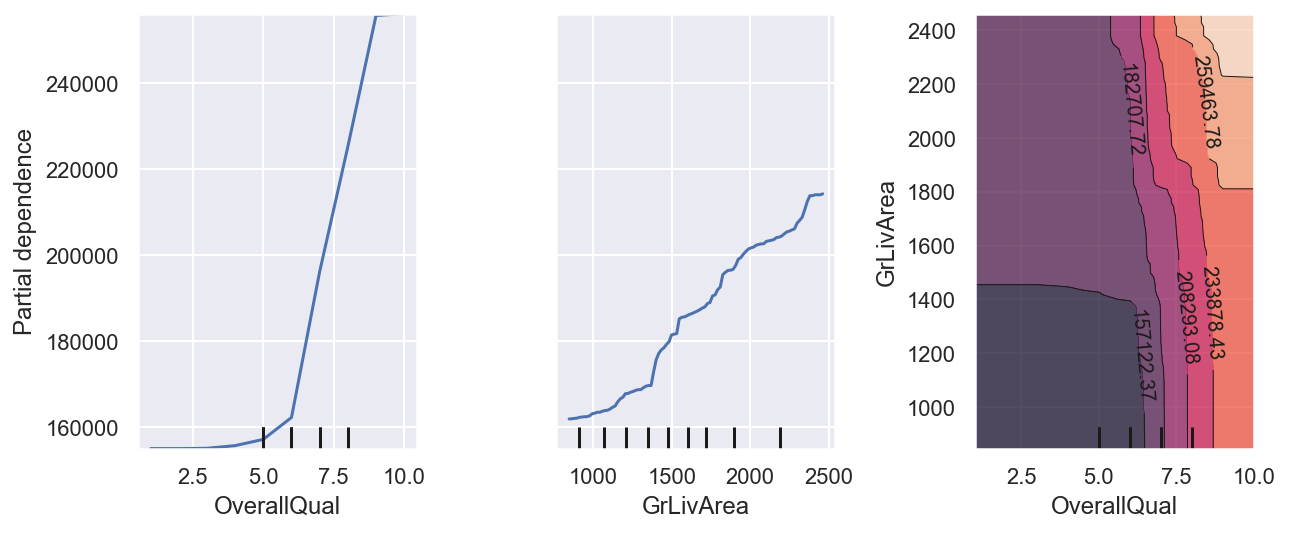

In [15]:
from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10,4))
ax = plt.gca()

features = [relevant_feat[0], relevant_feat[1], (relevant_feat[0], relevant_feat[1])]
PartialDependenceDisplay.from_estimator(rforest, X_train, features, method='brute', ax=ax)

plt.subplots_adjust(wspace=0.5)

___Comentario___
<br>

- De la primera gráfica podemos observar que a un mejor valor que la variable OverallQual, hará que el precio de venta de la casa aumente.

- La segunda variable GrLivArea, parece que no tiene tanta influencia en el precio de venta como la variable OverallQual.

- El precio de venta que se predice aumentará si los valores de OverallQual y GrLivArea interactúan entre sí, es decir las dos variables combinadas pueden hacer que el valor que se predice sea mayor.
<br>





<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

El gráfico anterior nos permite visualizar de forma global la relación de las variables con la salida. Imaginemos ahora que nos encontramos en la siguiente situación: una persona quiere poner a la venta su vivienda, pero el precio de venta que predecimos es más bajo del esperado. ¿Podemos explicarle el motivo de dicho resultado?


En este caso, se pretende expicar por qué obtenemos una predicción específica para una muestra específica. En estos casos, podemos utilizar SHAP para estudiar cómo los valores de las distintas variables afectan a la salida.

In [16]:
#!pip install shap

In [17]:
import shap

shap.initjs()

Vamos a estudiar algunas muestras individuales del conjunto de test para simular distintas situaciones. En concreto, vamos a seleccionar las muestras más cercanas a los percentiles 0, 0.25, 0.5, 0.75 y 1 (en cuanto a valor de *y*) en las predicciones del conjunto de test. El 0 corresponderá a la muestra con la predicción de precio más bajo, mientras que 1 sería la muestra de test con la predicción más alta.

In [18]:
y_pred = rforest.predict(X_test)
pcen = np.percentile(y_pred, [0, 25, 50, 75, 100], interpolation='nearest')
i_near = [abs(y_pred - i).argmin() for i in pcen]
samples = X_test.iloc[i_near, :]
samples.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1101,60.0,8400,2,5,1920,1950,0.0,290,0,0,...,0,0,0,1,0,0,0,0,1,0
143,71.0,8520,5,4,1952,1952,0.0,507,0,403,...,0,0,0,1,0,0,0,0,1,0
56,100.0,10175,6,5,1964,1964,272.0,490,0,935,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,1,0,0,0,0,1,0
1183,160.0,15623,10,5,1996,1996,0.0,2096,0,300,...,0,0,0,1,1,0,0,0,0,0


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 5</font> 

Dibujar los gráficos de fuerzas SHAP para cada una de las 5 muestras seleccionadas. Comentar los resultados.

In [19]:
explainer = shap.TreeExplainer(rforest)

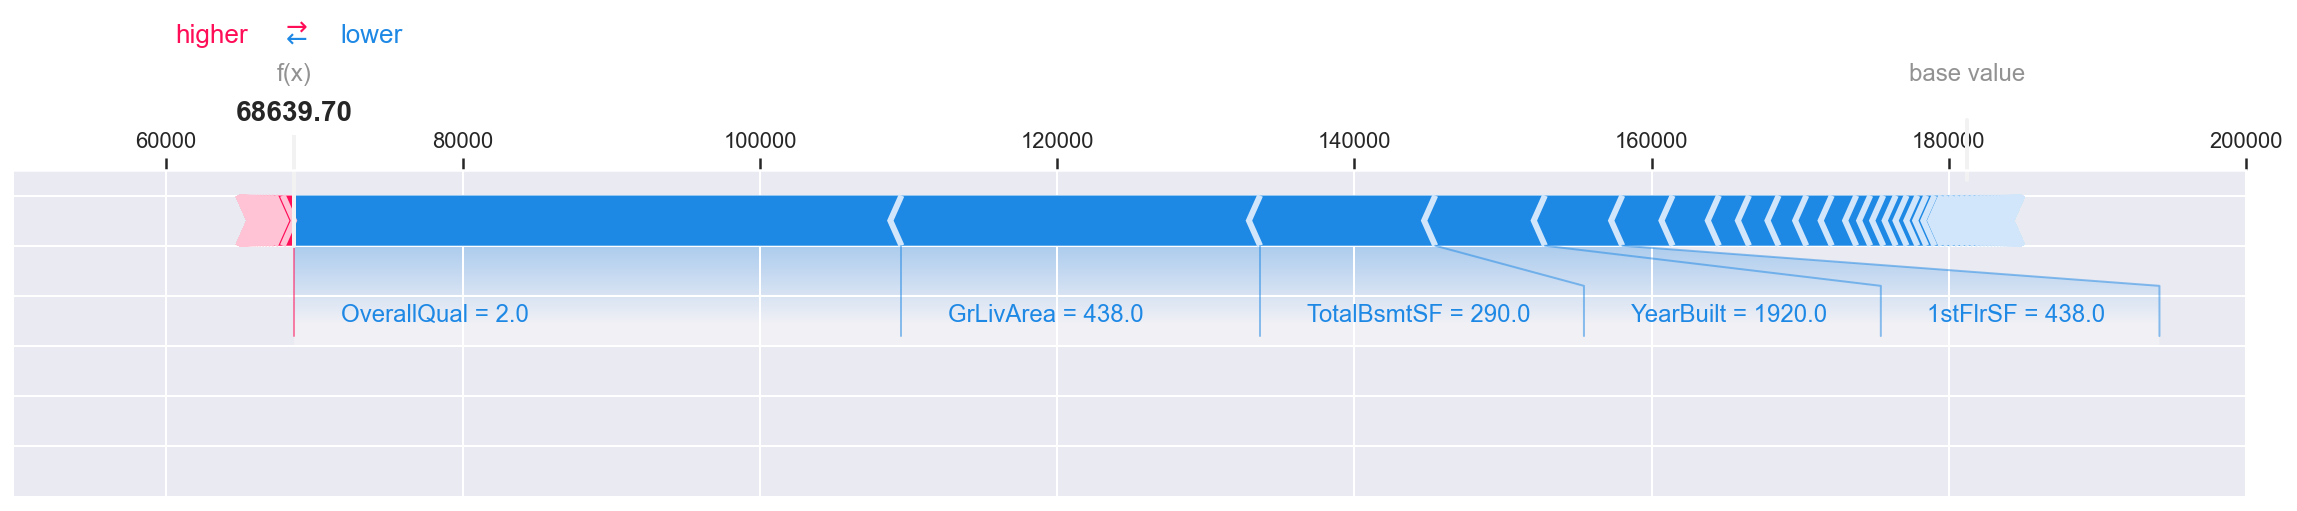

In [20]:
sample = 0

shap_values = explainer.shap_values(samples.iloc[sample])
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample], matplotlib=True)

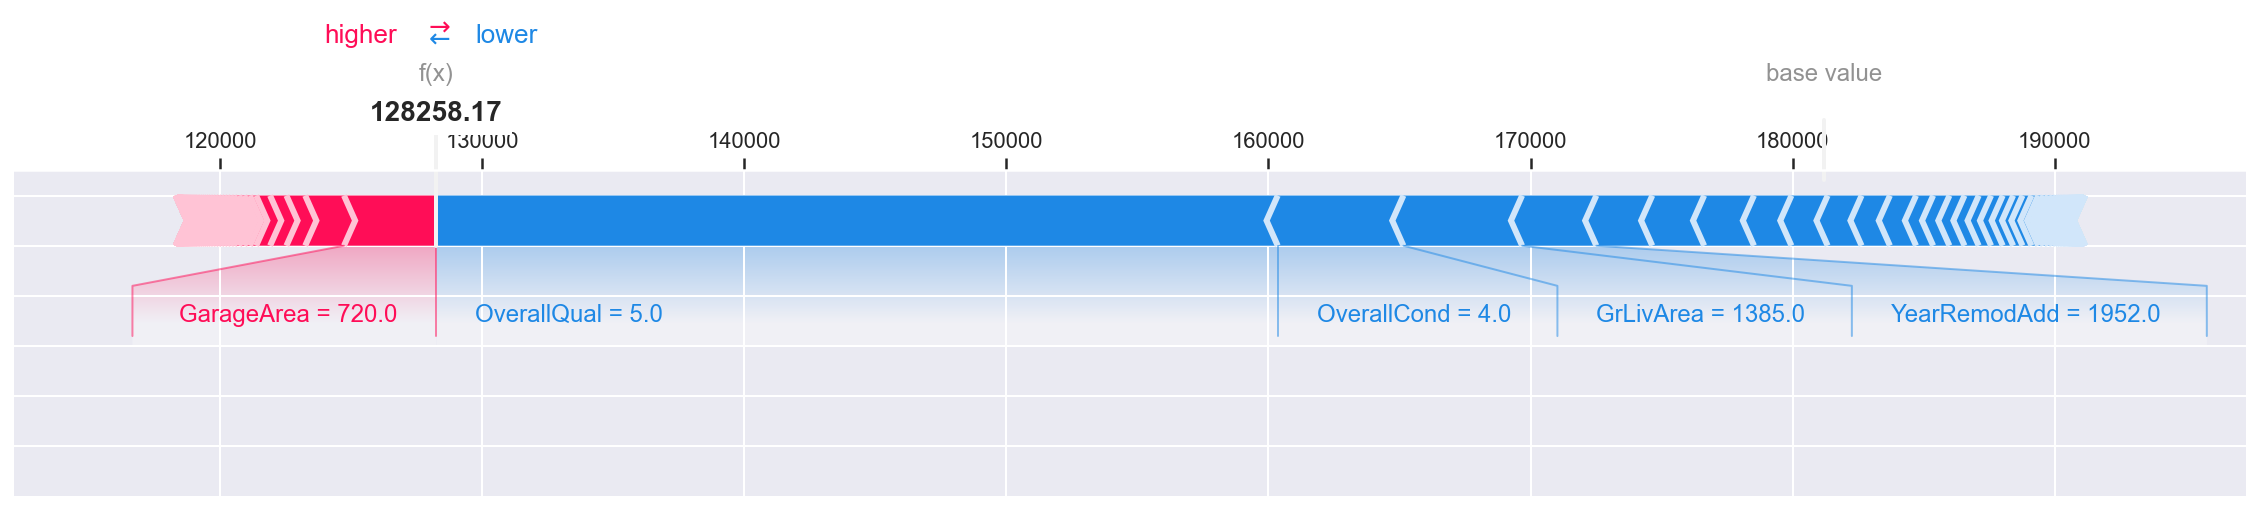

In [21]:
sample = 1

shap_values = explainer.shap_values(samples.iloc[sample])
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample], matplotlib=True)

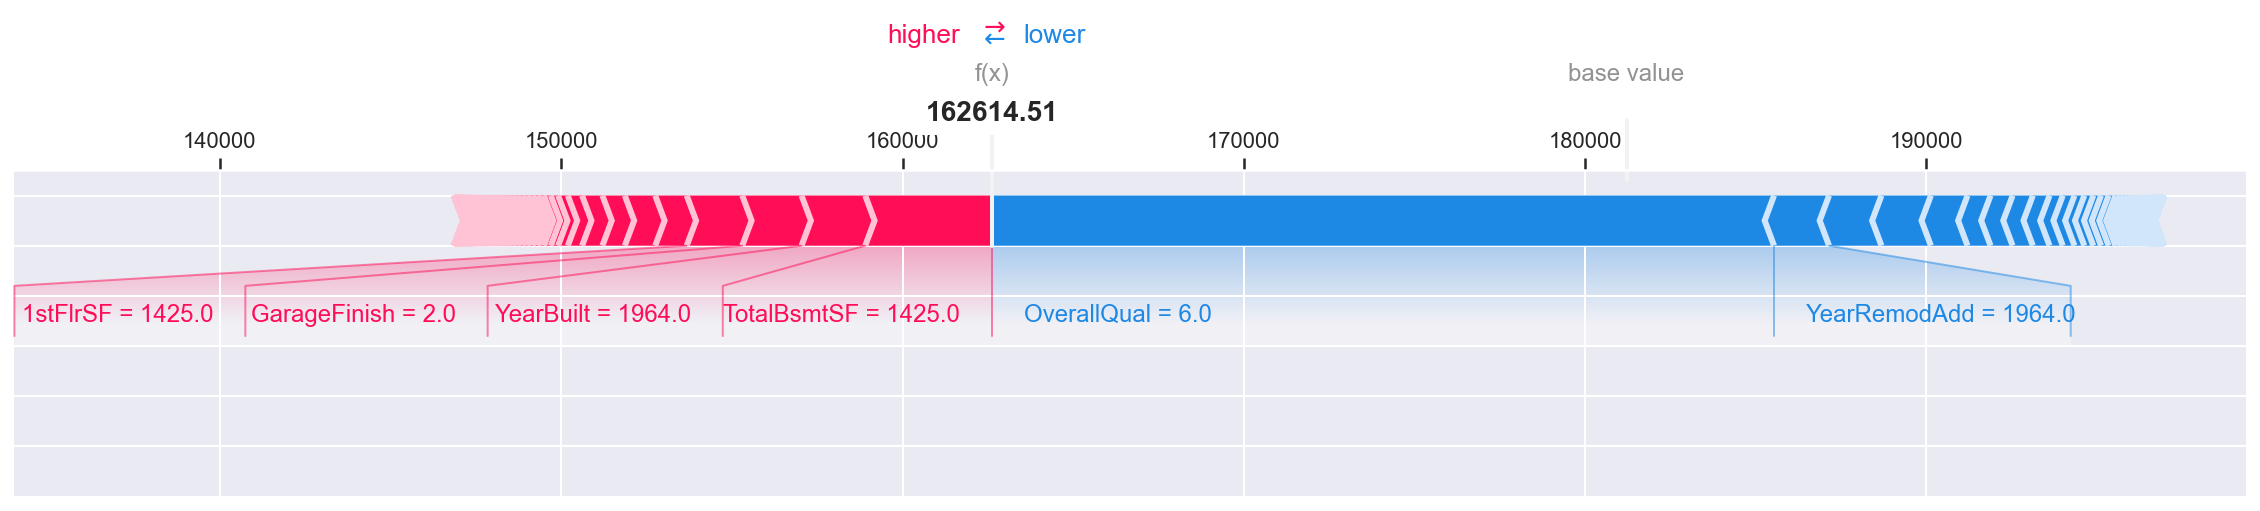

In [22]:
sample = 2

shap_values = explainer.shap_values(samples.iloc[sample])
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample], matplotlib=True)

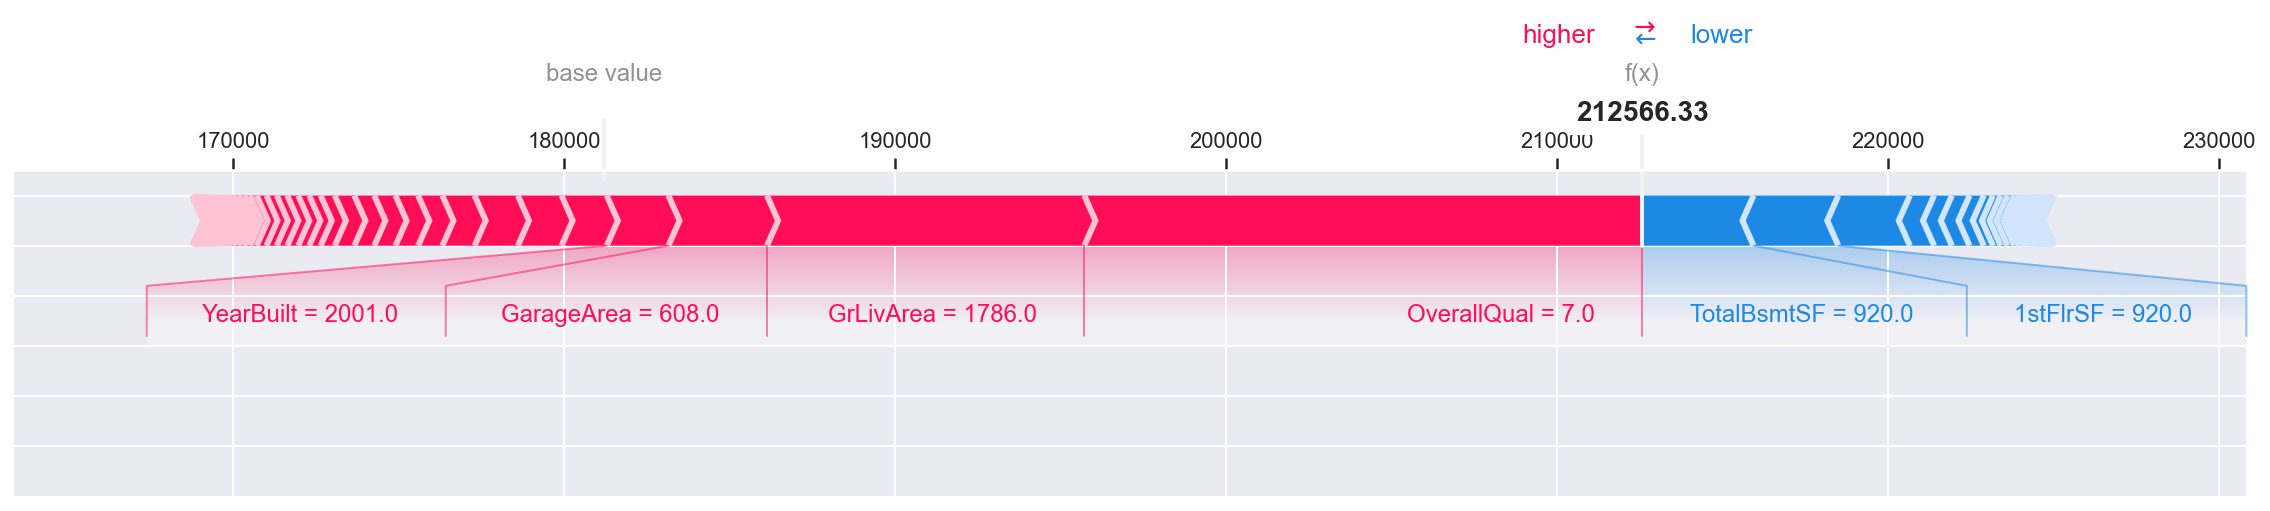

In [23]:
sample = 3

shap_values = explainer.shap_values(samples.iloc[sample])
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample], matplotlib=True)

In [24]:
#

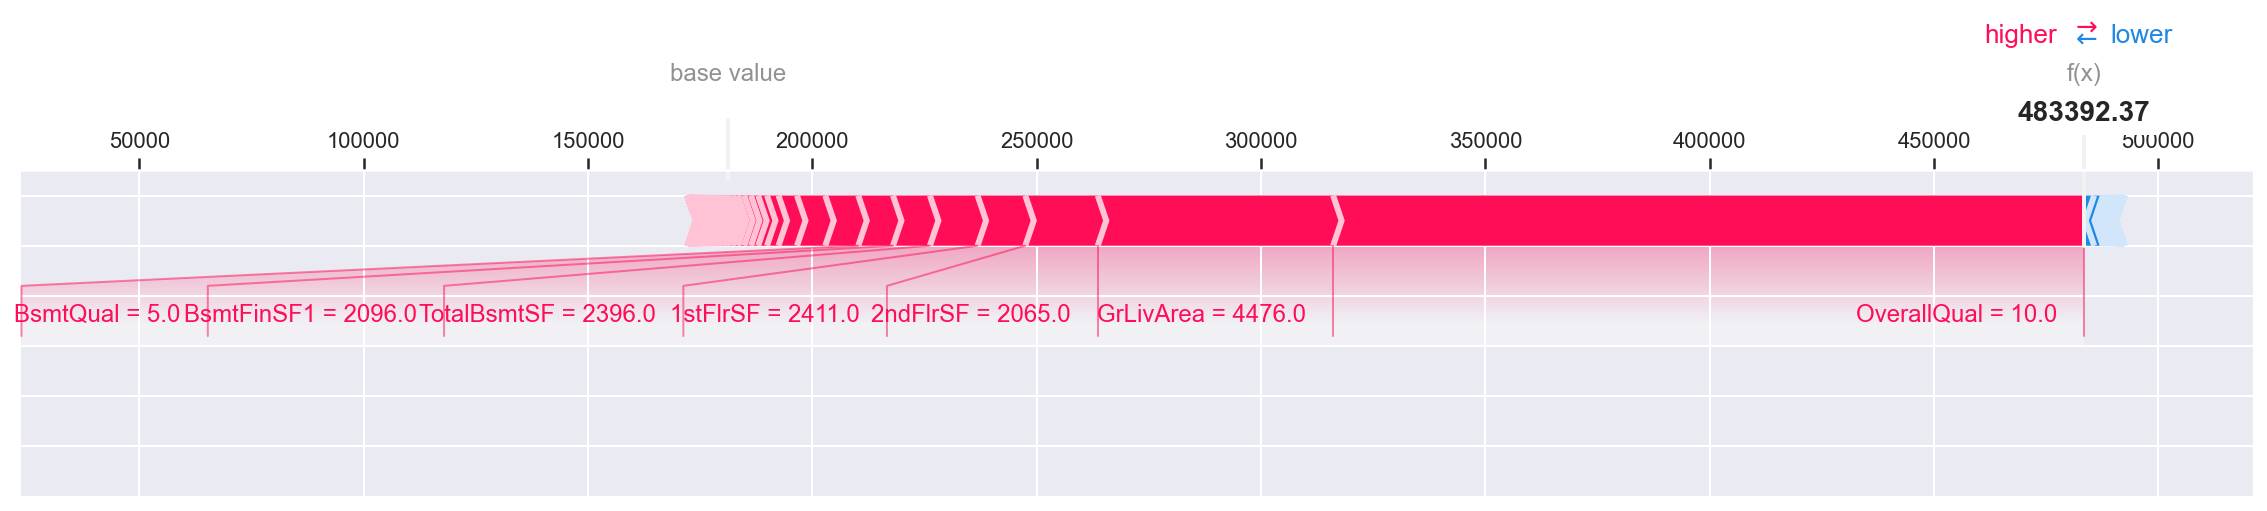

In [25]:
sample = 4

shap_values = explainer.shap_values(samples.iloc[sample])
shap.force_plot(explainer.expected_value, shap_values, samples.iloc[sample], matplotlib=True)

___Comentario___
<br>

- En el gráfico de la primera muestra podemos observar que un valor bajo de las variables 'OverallQual', 'GrLivArea', 'TotalBsmtSF' y 'YearBuilt', hace que el valor predicho se el más bajo. Sobretodo destaca la variable 'OverallQual' como la que más influye.

- Para la segunda muestra podemos ver como el valor de GrLivArea ha aumentado, esto ayuda positivamente a que el valor de la predicción sea mayor. Aumenta el valor de predicción casi el doble que en la primera muestra y aunque el valor de 'OverallQual' también es bastante mayor sigue influyendo más que el resto a que el valor predicho sea bajo.

- Para la tercera muestra es bastante parecida a la anterior, auamenta el valor de 'GrLivArea' y también aumenta el valor de 'OverallQual', que aunque sigue influyendo en que el precio de predicción sea menor conforme aumenta influirá menos.

- En el gráfico de la cuarta muestra podemos observar como con un valor de 'GrLivArea'>2000 influye positivamente en el valor de predicción además de otras variables como en este caso 'YearBuilt', '2ndFlrSF', etc. También decir que la variable 'OverallQual', no varía de la tercera a la cuarta muestra y eso también parece que al no aumentar y las otras sí tiene un efecto positivo en el valor de la predicción.

- La quinta muestra debe tener los valores de las variables más altos y sobre todo 'OverallQual' es la que más influye.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 6</font> 

Dibuja un resumen global de los valores SHAP de todas las muestras de test con `summary_plot`. Comentar los resultados.

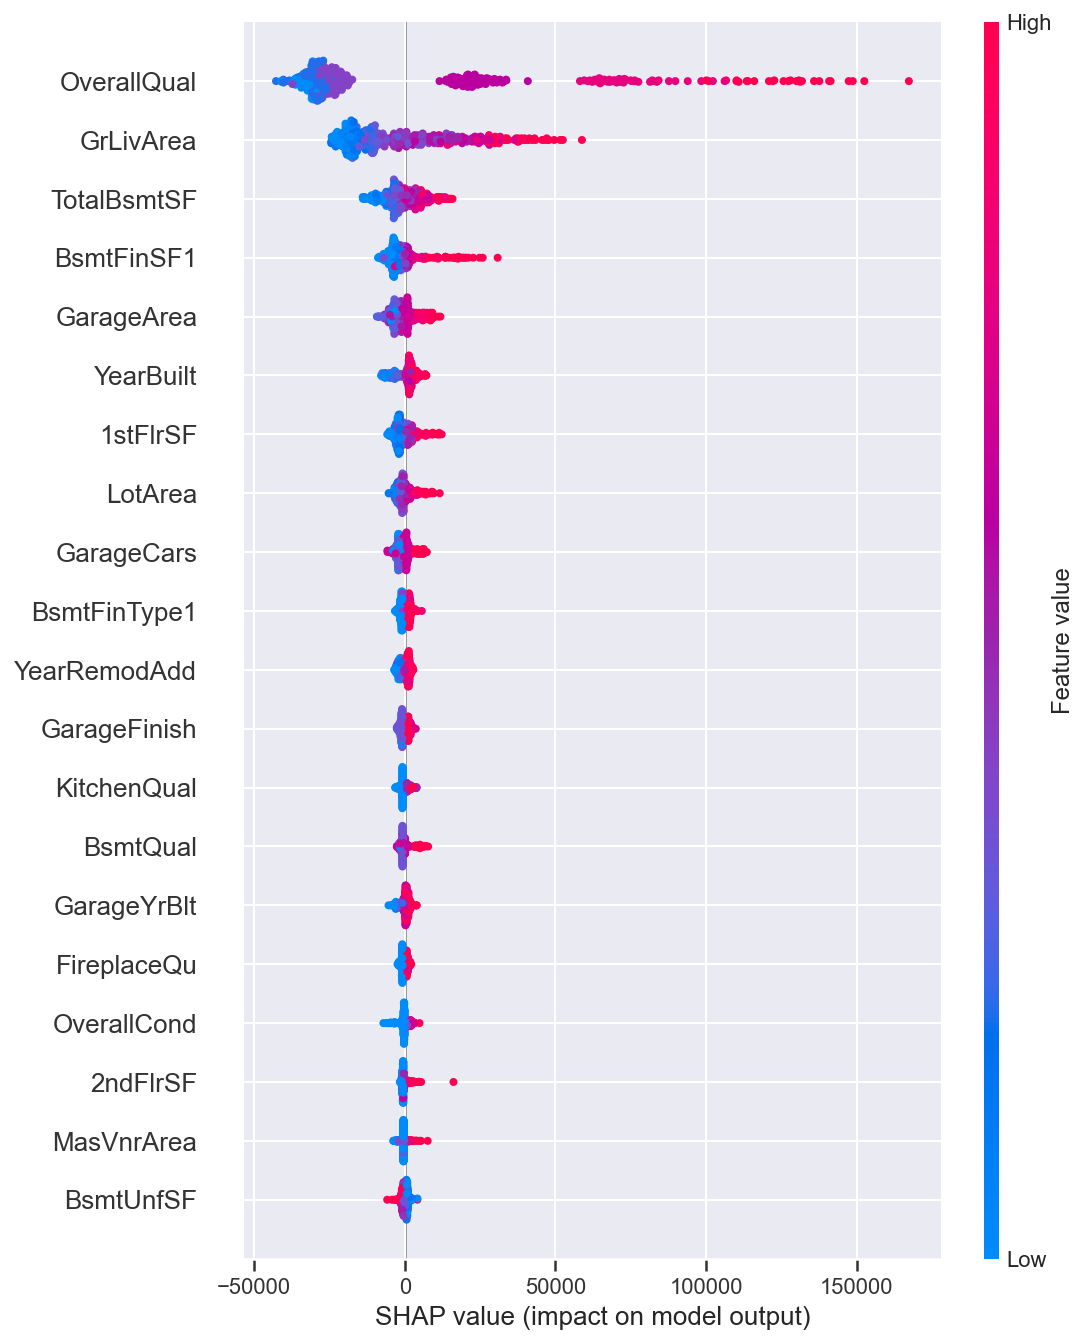

In [26]:
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

___Comentario___
<br>

Como ya se podia observar en los gráficos SHAP para muestras individuales, la variable 'OverallQual' con valores más altos es la que más influye en el valor de predicción, seguida de 'GrLivArea'.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section7"></a>
## <font color="#00586D"> 7. KNN</font>
<br>

Anteriormente se han usado algunos métodos paramétricos (regresión) y no paramétricos (árboles y *Random Forest*) para la predicción. KNN es otro método no paramétrico muy sencillo.


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 7</font> 

Entrenar un modelo de predicción utilizando el vecino más cercano. Como el conjunto de datos no es excesivamente alto en relación a las características, y este algoritmo es muy sensible a la "*Maldición de la dimensionalidad"*, en esta prueba se utilizarán solamente las características numéricas relevantes obtenidas anteriormente con *Random Forest*, y almacenadas en `relevant_feat` durante el proceso de exploración.  

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train[relevant_feat], y_train)

description = '1-NN (Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.763		R² = 0.618		R² = 0.678
MAE = 24834.66					MAE = 28405.04


Puede apreciarse que el rendimiento de este algoritmo es muy pobre ($R^2=0.504$ en validación). A continuación se creará un *pipeline* para estandarizar los datos antes de hacer la predicción.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_knn = Pipeline([('scaler',StandardScaler()),
                    ('knn',KNeighborsRegressor())])

pipe_knn.fit(X_train[relevant_feat], y_train)


description = '1-NN (Relevant-STD)'
show_results(description, pipe_knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.875		R² = 0.803		R² = 0.773
MAE = 17295.36					MAE = 21264.16


En este caso, sube de manera sustancial el $R^2$ para el conjunto de validación. ¿Qué sucece?

___Comentario___
<br>

Sucede que como KNN calcula la distancia entre dos puntos, los valores más grandes pueden hacer que el modelo se enfoque en estas variables y se pierda información valiosa de las variables con valores pequeños.

Al estandarizar los datos, todas las variables tienen la misma importancia y la misma escala, lo que ayuda a prevenir la dominación de variables con valores más grandes. Esto puede resultar con una mayor precisión en las predicciones.
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 8</font> 

Analizar el funcionamiento de KNN con distintos valores para `k`, utilizando pesos uniformes o inversos a la distancia para agregar los valores de los vecinos. En primer lugar, utilizando **todas las variables** (`X_train`) y estandarización.

In [29]:
pipe_knn = Pipeline([('scaler',StandardScaler()),
                    ('knn',KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters,cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

knn = search.best_estimator_
description = 'k-NN (STD)'
show_results(description, knn, X_train, y_train, X_test, y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.732		R² = 0.698
MAE = 0.00					MAE = 25710.12


Puede hacerse la predicción utilizando solamente las características relevantes obtenidas con `Random Forest` (`relevant_feat`).

In [30]:
pipe_knn = Pipeline([('scaler',StandardScaler()),
                    ('knn',KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.810		R² = 0.792
MAE = 0.00					MAE = 20210.55


Comparar y comentar los resultados de ambas pruebas.

___Comentario___
<br>

Podemos observar que el modelo entrenado con las caracteristicas más relevantes, está mejor ajustado, lo que sugiere que generaliza mejor que el modelo entrenado con todos los datos.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section8"></a>
## <font color="#00586D"> 8. Construcción de características</font>
<br>

La construcción de características puede llevarse a cabo de varias formas. Un enfoque es el que se apoya en una construcción exhaustiva, como por ejemplo se puede hacer con el módulo *Feature Creation* de la librería `feature-engine`[**(+ Inf)**](https://feature-engine.readthedocs.io/en/latest/index.html), seguida de selección; un segundo enfoque se basa en la construcción mediante técnicas más complejas, como la programación genética+autoML; por último, también es posible construir características de manera manual a partir de la exploración. En este proyecto utilizaremos este último enfoque para construir algunas características sencillas. Para ello utilizaremos un conjunto de datos auxiliar, al que denominaremos `data_feat()`.

In [31]:
data_feat = data.copy()

Durante la exploración se observó que la distribución del precio de venta está claramente sesgada. En estos casos, es conveniente trabajar con el logaritmo. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 9</font> 

Calcular el logaritmo de los valores de la columna `data_feat['SalePrice'] `, almacenar el resultado en `data_feat['SalePrice']` y visualizar la distribución con una gráfica de  tipo `histplot`.

In [32]:
data_feat['SalePrice'] = np.log(data_feat['SalePrice'])

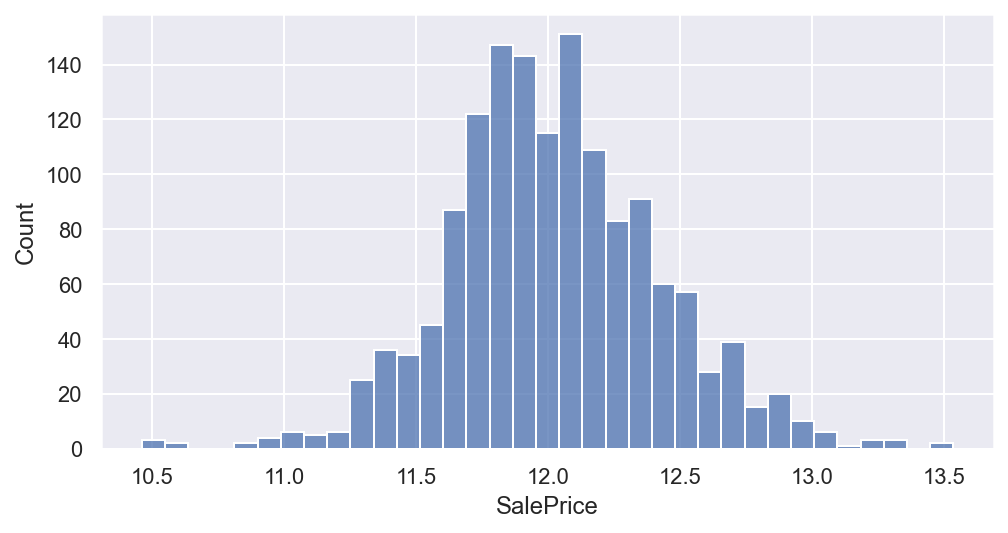

In [33]:
plt.figure(figsize=(8,4))
sns.histplot(data=data_feat, x='SalePrice')
plt.show()

También se ha observado que la relación de la variable `OveralQuality`, una de las más correlacionadas, era más fuerte con respecto al logaritmo de la variable `SalesPrice`.

Otra variable imortante, `GrLivArea`, también está sesgada. Sustituirla también por su logaritmo.

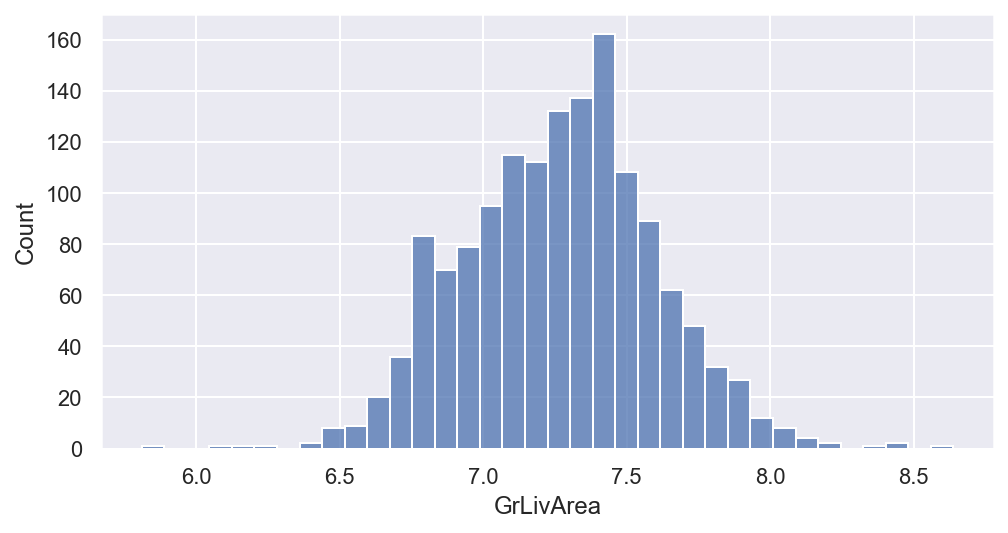

In [34]:
data_feat['GrLivArea'] = np.log(data_feat['GrLivArea'])
plt.figure(figsize=(8,4))
sns.histplot(data=data_feat, x='GrLivArea')
plt.show()

Por último, algunas variables numéricas representan datos temporales. Por ejemplo, en este conjunto de datos, el mes de venta. Aunque su repercursión no es muy fuerte, es conveniente saber tratar estas variables, ya que aparecen a menudo en distintos consumos de datos. A continuación se muestra la distribución de los precios en función del mes. 

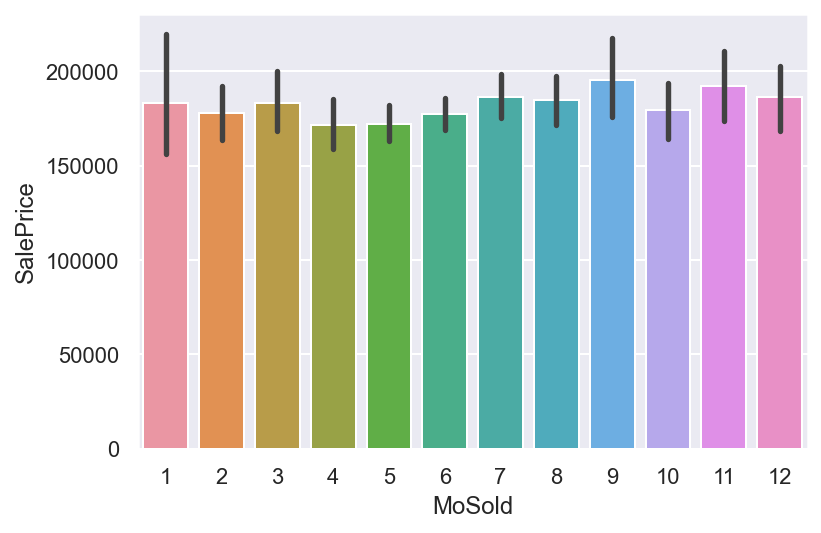

In [35]:
data_feat.sort_values(by='MoSold', inplace=True)
ax = sns.barplot(x=data_feat['MoSold'].astype('str'), y=data['SalePrice']);

Puede observarse que existe cierta oscilación en los precios y que depende del mes. También que el mes 1 y el 12, que representan valores extremos, realmente deberían ser similares, porque se suceden en el tiempo y, además, los precios medios son similares también. Vemos que los precios bajan en mayo y junio, y crecen en septiembre-noviembre. Estas particularidades no se representan mediante una relación lineal, pero se pueden representar mejor con una función sinusoidal.

(1.0, 13.0)

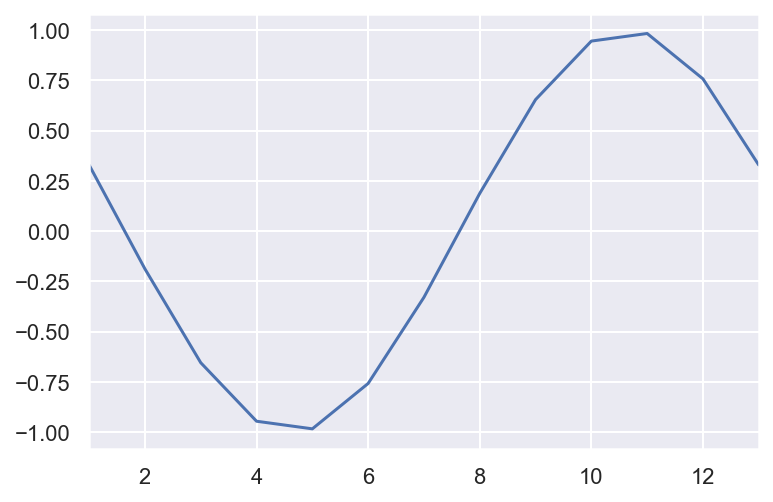

In [36]:
t = np.linspace(1,13, 13, endpoint=True)
ft = np.sin(2*np.pi*t/12-4)

plt.plot(t,ft)
plt.xlim(1,13)

Sustituir los valores de la columna `data_feat['MoSold']` por los obtenidos al calcular la función sinusoidal anterior.

In [37]:
data_feat['MoSold'] = np.sin(2*np.pi*data_feat['MoSold']/12-4)

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

Una vez transformadas las tres variables, se volverán a obtener los conjuntos de entrenamiento y test, ahora con algunas características transformadas.

In [38]:
from sklearn.model_selection import train_test_split

X = data_feat.drop(columns='SalePrice').copy()
y = data_feat['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 10</font> 

Volver a obtener los modelos de regresión lineal y árbol de regresión utilizando los conjuntos de datos obtenidos al transformar las características. Mostrar los resultados (visualizar el *DataFrame* `results`), y comentarlos.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Como la variable `SalePrice` es ahora un logaritmo, es necesario deshacer esa transformación para hacer el MAE. Esto solo implica pasar el argumento `is_log=True` a la función `show_results`. 
<br>

Para KNN, utilizad el *pipeline* para estandarizar los datos, y solo las características incluídas en `relevant_feat`.
</div>

In [39]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(),parameters,cv=5)
search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT)'
show_results(description, ridge, X_train, y_train, X_test, y_test, True)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.938		R² = 0.900		R² = 0.835
MAE = 12321.07					MAE = 17959.86


In [40]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(),parameters,cv=5)
search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree (FT)'
show_results(description, tree, X_train, y_train, X_test, y_test, True)

{'max_depth': 10.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.968		R² = 0.735		R² = 0.728
MAE = 9752.40					MAE = 25828.67


In [41]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(),parameters,cv=5)
search.fit(X_train,y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest (FT)'
show_results(description, rforest, X_train, y_train, X_test, y_test, True)

{'max_depth': 20}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.982		R² = 0.865		R² = 0.861
MAE = 6647.99					MAE = 18417.51


In [42]:
pipe_knn = Pipeline([('scaler',StandardScaler()),
                    ('knn',KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

knn = search.best_estimator_

description = 'k-NN (STD - Relevant - FT)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test, True)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 1.000		R² = 0.832		R² = 0.814
MAE = 8.49					MAE = 21357.19


In [43]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.712616,0.734017,20723.767792,26399.467551
Random forest,0.975352,0.856316,0.847407,7855.832431,17372.203457
Ridge regression (Relevant),0.839021,0.825211,0.714174,20444.036513,21965.317969
Regression tree (Relevant),0.952867,0.716401,0.755760,12982.552518,24778.627430
Random forest (Relevant),0.979140,0.849097,0.849357,6757.485652,17738.925651
1-NN (Relevant),0.762804,0.617536,0.677889,24834.659509,28405.038174
1-NN (Relevant-STD),0.875446,0.803151,0.773045,17295.361759,21264.161826
k-NN (STD),1.000000,0.732469,0.698286,0.000786,25710.122559


___Comentario___
<br>

Se observa que los modelos que usan las variables transformadas tienden a tener un mejor rendimiento. En concreto el modelo de Ridge regression (FT). 
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section9"></a>
## <font color="#00586D"> 9. Descarte de outliers</font>
<br>

Llegado a este punto se aprecia que el mejor resultado se ha obtenido con la regresión regularizada (nos basamos en la validación para la selección de modelos), tras transformar algunas características, y utilizando todas las demás.  En algunos casos, los valores anómalos pueden perjudicar al modelo. En regresión, por ejemplo, pueden hacer que algún coeficiente se altere de manera sustancial, sobre todo si el conjunto de datos no es grande.

Por último, se comprobará el efecto de eliminar valores anómalos. 




#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 11</font> 

Utilizar un modelo *Isolation Forest* para "marcar" las muestras que son *outliers*, tanto en el conjunto de entrenamiento como en el conjunto de test. Utilizar una contaminación del 0.5%.  Generar dos vectores (`out_train` y `out_test`) con los resultados (1 para valores normales, y -1 para *outliers*). ¿Cuantos *outliers* hay en el conjunto de entrenamiento? ¿Y en el de test?

In [44]:
from sklearn.ensemble import IsolationForest

iforest =  IsolationForest(contamination=0.5)
iforest.fit(X_train)
out_train =  iforest.predict(X_train)
out_test =  iforest.predict(X_test)

X does not have valid feature names, but IsolationForest was fitted with feature names


In [45]:
numero_out_train = np.count_nonzero(out_train == -1)
numero_out_test = np.count_nonzero(out_test == -1)
print("Número de outliers en conjunto de entrenamiento:", numero_out_train)
print("Número de outliers en conjunto de test:", numero_out_test)

Número de outliers en conjunto de entrenamiento: 489
Número de outliers en conjunto de test: 236


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 12</font> 

Eliminar los outliers  de los conjuntos de entrenamiento y test, y entrenar el modelo de regresión lineal regularizada (el mejor modelo hasta el momento). ¿Qué resultados se obtienen?

In [46]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(),parameters,cv=5)
search.fit(X_train[out_train == 1],y_train[out_train == 1])
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT - No Outliers)'
show_results(description, ridge , X_train[out_train == 1], y_train[out_train == 1], X_test[out_test == 1], y_test[out_test == 1], True)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.940		R² = 0.894		R² = 0.928
MAE = 8805.52					MAE = 9632.44


In [47]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression,0.907758,0.845827,0.775932,15187.837606,19274.550173
Regression tree,0.875838,0.712616,0.734017,20723.767792,26399.467551
Random forest,0.975352,0.856316,0.847407,7855.832431,17372.203457
Ridge regression (Relevant),0.839021,0.825211,0.714174,20444.036513,21965.317969
Regression tree (Relevant),0.952867,0.716401,0.755760,12982.552518,24778.627430
Random forest (Relevant),0.979140,0.849097,0.849357,6757.485652,17738.925651
1-NN (Relevant),0.762804,0.617536,0.677889,24834.659509,28405.038174
1-NN (Relevant-STD),0.875446,0.803151,0.773045,17295.361759,21264.161826
k-NN (STD),1.000000,0.732469,0.698286,0.000786,25710.122559


___Comentario___
<br>

Como podemos observar al eliminar los outliers, el modelo ridge ha mejorado con respecto a los anteriores.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Incorporar este paso al pipeline sería bastante complejo porque no solo modificamos columnas, sino que eliminamos filas. Habría que hacer un *metaclasificador* que primero determine si un valor es un outlier o no, y en función de eso devuelva el resultado (que puede ser -1 para un caso, y la predicción para otro). La implementación de este *pipeline* constituye un ejercicio interesante.
</div>

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section10"></a>
## <font color="#00586D">10. Aprendizaje no supervisado: PCA, Manifold y EM</font>
<br>

Para analizar el conjunto de datos mediante aprendizaje no supervisado se partirá del conjunto de datos original. En este caso trabajaremos solamente con las caracterícticas numéricas más relevantes y el precio.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Estos ejercicios **no son una continuación** de los relacionados con el modelo predictivo, sino que constituyen una estudio independiente. 
</div>

In [48]:
feat = ['OverallQual',
        'GrLivArea',
        'ExterQual',
        'KitchenQual',
        'GarageArea',
        'TotalBsmtSF',
        '1stFlrSF',
        'TotRmsAbvGrd',
        'YearBuilt',
        'SalePrice']

data_small = data[feat]
data_small.head()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,SalePrice
Id,,,,,,,,,,
1,7,1710,4,4,548,856,856,8,2003,208500
2,6,1262,3,3,460,1262,1262,6,1976,181500
3,7,1786,4,4,608,920,920,6,2001,223500
4,7,1717,3,4,642,756,961,7,1915,140000
5,8,2198,4,4,836,1145,1145,9,2000,250000


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 13</font>

Utilizar PCA para reducir la dimensionalidad del conjunto de datos `data`. Utilizar dos componentes y almacenar la proyección en una variable denominada `data_pc`. Mostrar la proporción de varianza mostrada por cada componente. Dibujar una gráfica de dispersión con los valores de las dos primeras características creadas (proyecciones correspondientes a las dos componentes). ¿Qué se observa? (Se puede utilizar como color, por ejemplo, `hue=data['SalePrice']`).

In [49]:
from sklearn.decomposition import PCA

pca =  PCA(n_components=2)
data_pc = pca.fit_transform(data_small)

print(f'Número de componentes: {data_pc.shape[1]}')

Número de componentes: 2


In [50]:
pca.explained_variance_ratio_

array([9.99939689e-01, 3.07433049e-05])

Muestra las cargas de las dos componentes (los 5 valores más importantes)

In [51]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('SalePrice', 0.9999775001384429),
 ('GrLivArea', 0.004687280321356568),
 ('TotalBsmtSF', 0.003388405536137294),
 ('1stFlrSF', 0.002948274914306238),
 ('GarageArea', 0.00167783226255154)]

In [52]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('TotalBsmtSF', 0.6791609607994287),
 ('1stFlrSF', 0.6292308359316411),
 ('GrLivArea', 0.3688814659467971),
 ('GarageArea', 0.08179587383298015),
 ('TotRmsAbvGrd', 0.0007980145158197117)]

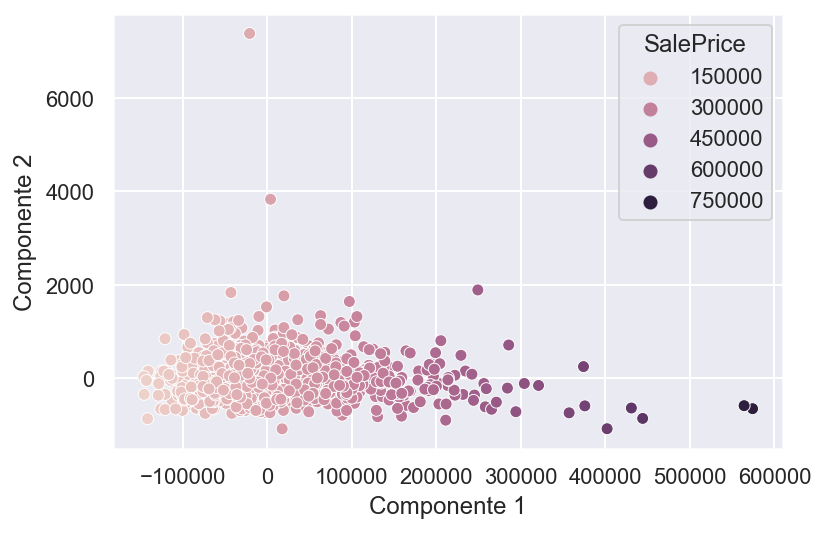

In [53]:
sns.scatterplot(x=data_pc[:, 0], y=data_pc[:, 1], hue=data['SalePrice'])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

___Comentario___
<br>

La gráfica muestra cómo las proyecciones en las dos componentes principales se relacionan con los valores de SalePrice. Los valores de SalePrice parecen aumentar en general a medida que las proyecciones en el Componente 1 aumentan.

<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 14</font>




Construir un *pipeline* en el que el primer paso consista en escalar las características a media cero y desviación uno mediante un objeto `StandardScaler`, y después se  repita el proceso anterior, almacenando la proyección de los datos en `data_pc`. Mostrar el número de componentes necesarias para retener el 99% de la varianza de los datos. ¿Son ahora tan relevantes las dos primeras componentes? ¿Por qué? ¿Cuánta varianza acumulan? ¿Podrían interpretarse de algún modo?

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipe_sc_pca =  Pipeline([('scaler',StandardScaler()),
                         ('pca', PCA(n_components=10))])

data_pc =  pipe_sc_pca.fit_transform(data_small)

print(f'Número de componentes: {data_pc.shape[1]}')

Número de componentes: 10


In [79]:
variance_ratio = np.cumsum(pipe_sc_pca[1].explained_variance_ratio_)
print(f'Número de componentes necesarios para retener el 99% de la varianza: {np.min(np.where(variance_ratio>0.99))}')

Número de componentes necesarios para retener el 99% de la varianza: 9


In [85]:
variance_ratio

array([0.56500482, 0.70361196, 0.79915492, 0.85408061, 0.89649085,
       0.92695371, 0.95310594, 0.97170598, 0.98738782, 1.        ])

In [81]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('SalePrice', 0.9999775001384429),
 ('GrLivArea', 0.004687280321356568),
 ('TotalBsmtSF', 0.003388405536137294),
 ('1stFlrSF', 0.002948274914306238),
 ('GarageArea', 0.00167783226255154)]

In [82]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('TotalBsmtSF', 0.6791609607994287),
 ('1stFlrSF', 0.6292308359316411),
 ('GrLivArea', 0.3688814659467971),
 ('GarageArea', 0.08179587383298015),
 ('TotRmsAbvGrd', 0.0007980145158197117)]

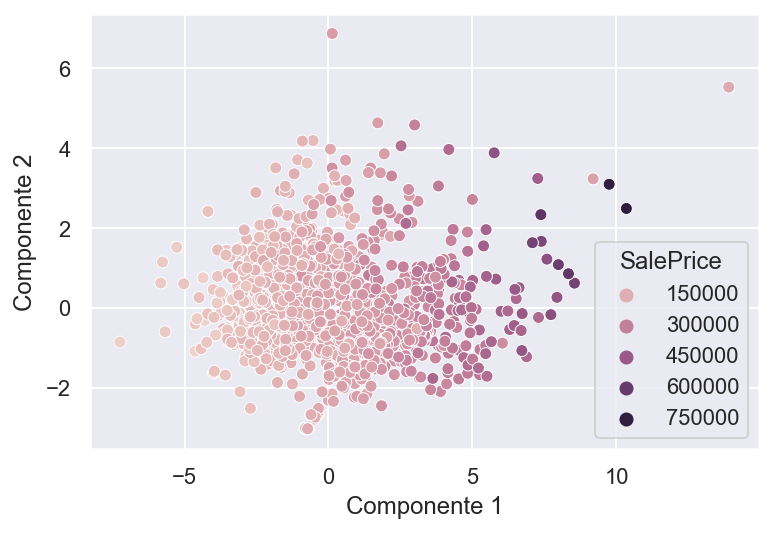

In [86]:
sns.scatterplot(x=data_pc[:, 0], y=data_pc[:, 1], hue=data['SalePrice'])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

___Comentario___
<br>

Como podemos observar ahora las dos componentes ya no son tan relevantes, esto puede ser debido a que al estandarizar los datos con StandardScaler(). Esto puede afectar a la contribución relativa de cada variable a la varianza total, lo que podría explicar por qué las dos primeras componentes no explican tanto como antes.

En la gráfica se interpreta como la estandarización ha tenido un efecto importante en la distribución de los valores.
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 15</font>

Repetir el ejercicio anterior, pero utilizando ahora TSNE. Para ello, crear un *pipeline* en el que el primer paso corresponda a la estadarización, y el segundo a un modelo TSNE en el que `n_components=2`. Utilizarlo para transformar los datos en `data_small` y almacenar el resultado en un array denominado `data_vis`.

In [87]:
from sklearn.manifold import TSNE

pipe_sc_tsne = Pipeline([('scaler',StandardScaler()),
                         ('tsne', TSNE(n_components=2))])

data_vis = pipe_sc_tsne.fit_transform(data_small)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


Elaborar una gráfica de dispersión con los datos de `data_vis`.

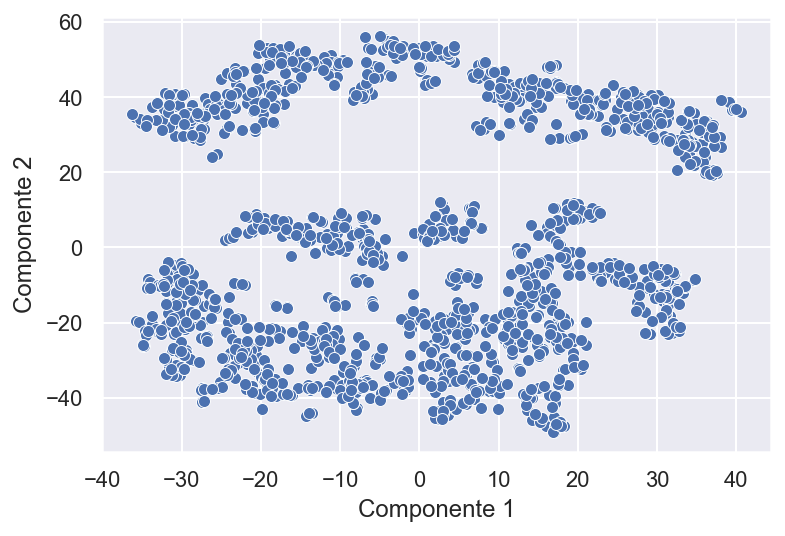

In [88]:
sns.scatterplot(x=data_vis[:, 0], y=data_vis[:, 1])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

Repetir la gráfica, pero utilizando `hue=data['SalePrice']` 

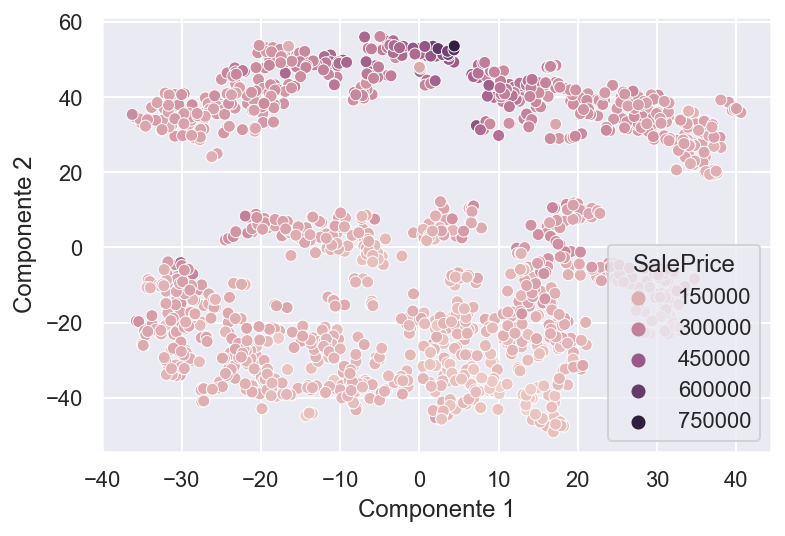

In [89]:
sns.scatterplot(x=data_vis[:, 0], y=data_vis[:, 1], hue=data['SalePrice'])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

Probar a utilizar el color para mostrar otra variables, como por ejemplo `YearBuilt`.

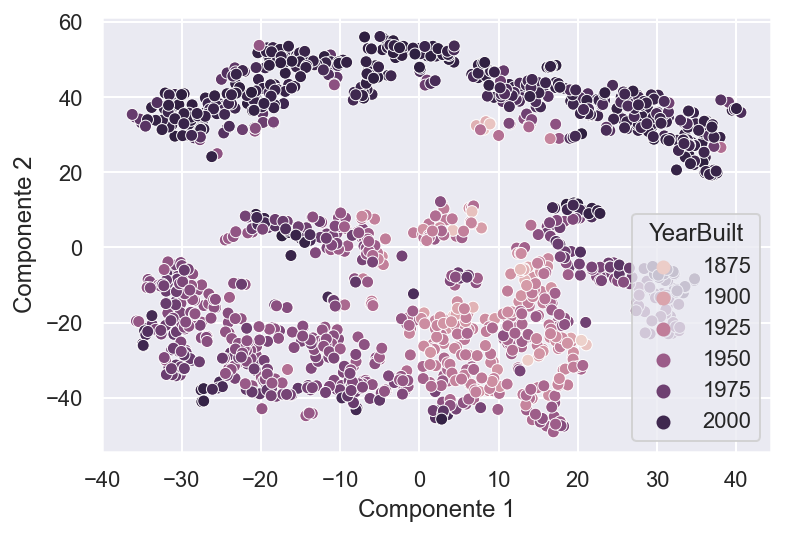

In [90]:
sns.scatterplot(x=data_vis[:, 0], y=data_vis[:, 1], hue=data['YearBuilt'])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

___Comentario___
<br>

Los puntos que son similares entre sí se agrupan tanto en el espacio original como en el espacio de menor dimensión.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 16</font>

Por último, se va a utilizar el algoritmo EM (modelo `GaussianMixture`) para representar la distribución de las viviendas que hay en `data_small`, y utilizando `n_components=2`.   En este caso, también es necesario utilizar un *pipeline* en el que el primer paso consista en una estandarización, y el segundo el propio algoritmo. Almacenar el cluster al que pertenece cada vivienda en `cluster`.

In [91]:
from sklearn.mixture import GaussianMixture

pipe_sc_gm = Pipeline([('scaler',StandardScaler()),
                         ('gm', GaussianMixture(n_components=2))])

cluster = pipe_sc_gm.fit_predict(data_small)

Obtener la media de todas las columnas para cada uno de los grupos y compararlos. ¿Puede hacerse algún tipo de interpretación?

In [93]:
data_means = pd.DataFrame(data_small).groupby(cluster).mean()
data_means

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd,YearBuilt,SalePrice
0,5.398895,1356.096133,3.000000,3.177901,398.436464,922.207735,1067.016575,6.207735,1957.350276,144086.441989
1,7.241441,1775.333333,4.041441,4.055856,594.533333,1277.926126,1318.531532,7.023423,1993.962162,240985.073874


Otra forma de interpretar los clusters es mediante visualización. Mostrar una gráfica de dispersión con las columnas `GrLivArea` y `SalePrice`. Utilizar  `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

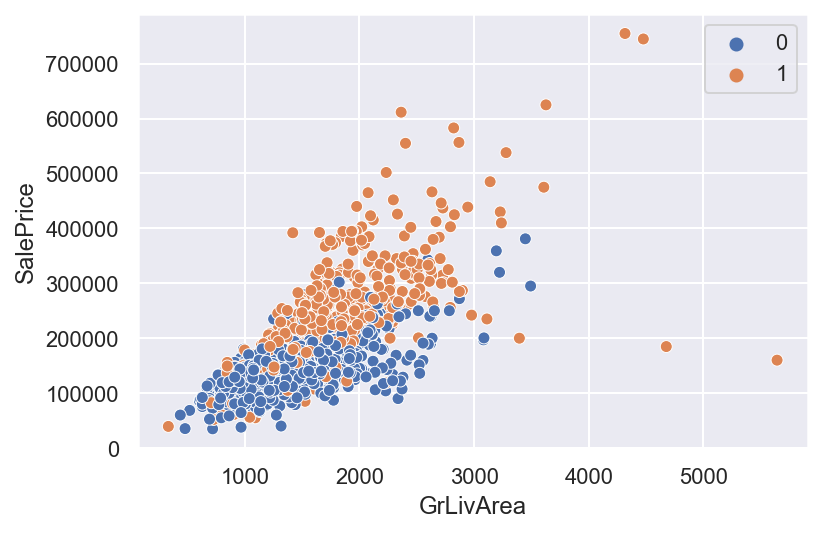

In [94]:
sns.scatterplot(data=data_small, x='GrLivArea', y='SalePrice', hue=cluster)

Elaborar ahora una gráfica de dispersión, pero con los datos de `data_pc`, utilizando otra vez `hue=cluster`. ¿Puede hacerse algún tipo de interpretación? 

<AxesSubplot:>

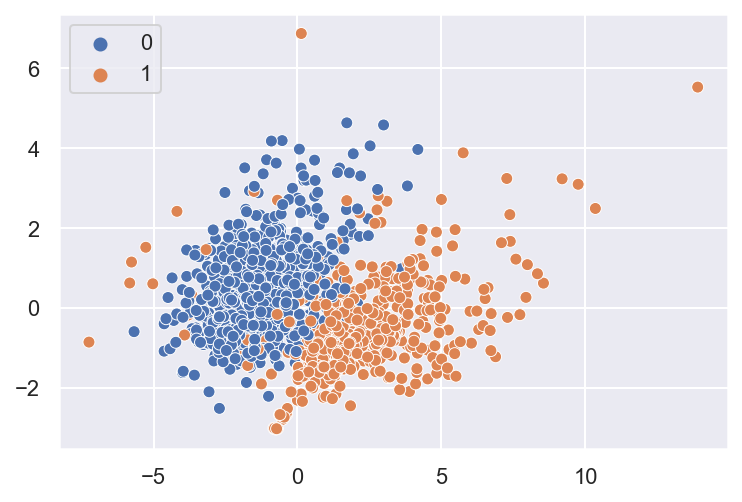

In [96]:
sns.scatterplot(data=data_pc, x=data_pc[:, 0], y=data_pc[:, 1], hue=cluster)

Repetir la gráfica, pero con los datos en `data_vis`. ¿Puede hacerse algún tipo de interpretación? 

<AxesSubplot:>

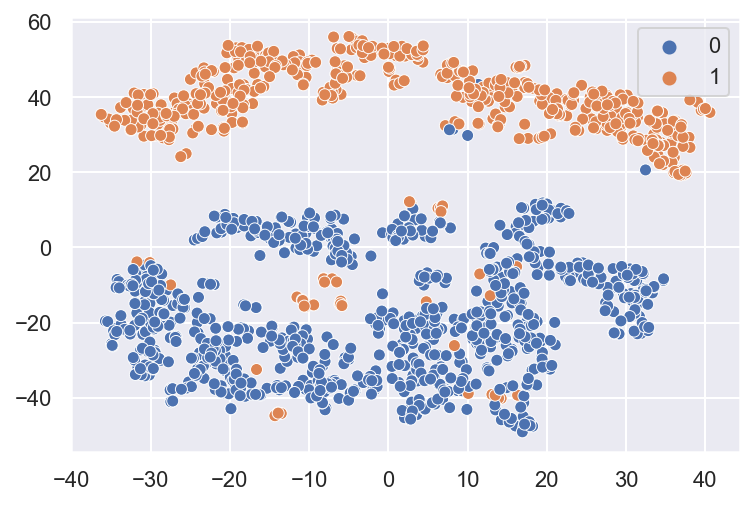

In [97]:
sns.scatterplot(data=data_vis, x=data_vis[:, 0], y=data_vis[:, 1], hue=cluster)

___Comentario___
<br>

En la tabla con la media de todas las columnas para cada uno de los grupos, se puede observar que las viviendas en el grupo 1 pueden ser más grandes, más nuevas y más caras en general.

-La primera gráfica la mayoría de precios del grupo 1 son a partir de 200000, mientras que casi todas las del grupo 0 su precio máximo son 200000.

-La segunda gráfica se ven dos grupos bastante definidos.

-La tercera gráfica como podemos ver los grupos entán bastante definidos en los que más precio tienen, salvo algún valor que se escapa hacia el grupo 0.
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>